## 1. Package Installation

In [1]:
import numpy as np 
import pandas as pd 
import shap
import matplotlib.pyplot as plt
import pylab as plt
import matplotlib
from matplotlib import pylab as plt

from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid, KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn import datasets
import warnings
warnings.filterwarnings("ignore")

## 2. Load Data

In [16]:
#Everytime you run this you will have to restart the Kernal otherwise it will go back too far 
#cd ..
df = pd.read_csv("Data/insurance.csv")
df.drop(["id","Vintage"],axis = 1,inplace=True)
print(df.shape)
df.head()

(381109, 10)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,0


In [17]:
# let's separate the feature matrix X, and target variable y
y = df['Response'] # we want to predict target variable
X = df.loc[:, df.columns != 'Response'] # all other columns are features
ftr_names = X.columns
#baseline view
classes, counts = np.unique(y,return_counts=True)
baseline = np.max(counts/len(y))
print('baseline:',baseline )

baseline: 0.877436638861848


## 6 Data Preprocessing

In [6]:
def ML_pipeline_kfold_GridSearchCV_RF(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # KFold splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    
    # collect which encoder to use on each feature
    ordinal_ftrs = ['Vehicle_Age'] 
    ordinal_cats = [['< 1 Year','1-2 Year','> 2 Years']]
    onehot_ftrs = ['Gender','Driving_License','Vehicle_Damage','Previously_Insured']
    num_ftrs = ['Age', 'Region_Code','Annual_Premium', 'Policy_Sales_Channel']
    #transform features
    ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(categories = ordinal_cats))])
    onehot_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    # collect all the encoders
    preprocessor = ColumnTransformer(
        transformers=[
            ('ord', ordinal_transformer, ordinal_ftrs),
            ('onehot', onehot_transformer, onehot_ftrs),
            ('num', num_transformer, num_ftrs)])
    
    # make ML pipeline
    pipe = make_pipeline(preprocessor, RandomForestClassifier(n_estimators = 100,random_state=random_state))
    # the parameters to tune
    param_grid = {'randomforestclassifier__max_depth': [1, 3, 10], # the max_depth should be smaller or equal than the number of features roughly
                'randomforestclassifier__max_features': [0.5,1.0]} # linearly spaced between 0.5 and 1
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True,n_jobs=-1)
    # kfold CV on other
    grid.fit(X_other, y_other)
    y_pred = grid.predict(X_test)
    preprocessor.fit(X_other)
    return grid, grid.score(X_test, y_test), X_test, y_test              

In [7]:
test_scores = []

for i in range(5):
    print('random state '+str(i+1)) 
    grid, test_score, X_test, y_test = ML_pipeline_kfold_GridSearchCV_RF(X,y,i*42, 5)
    print(grid.best_params_)
    print(i)
    print('best CV score:',grid.best_score_)
    #print('test score:',test_score)

    test_scores.append(test_score)
    
mean_test_scores = np.around(np.mean(test_scores),3)
std_test_scores = np.around(np.std(test_scores),3)
print('test accuracy:',mean_test_scores ,'+/-',std_test_scores)

# store mean and std of model's accuracy test score
model_mean = []
model_std = []
model_mean.append(mean_test_scores)
model_std.append(std_test_scores)

random state 1
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.5}
0
best CV score: 0.8763421342134213
random state 2
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.5}
1
best CV score: 0.8739588244538741
random state 3
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.5}
2
best CV score: 0.8759429514380009
random state 4
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.5}
3
best CV score: 0.8727714914348578
random state 5
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.5}
4
best CV score: 0.8687945937450887
test accuracy: 0.873 +/- 0.011


In [10]:
# run pipeline on the best iteration
grid, test_score, X_test, y_test= ML_pipeline_kfold_GridSearchCV_RF(X,y,1*42,5)
print(grid.best_score_)#mean test score
print(grid.score(X_test,y_test))
print(grid.best_params_)

0.8739588244538741
0.8716323296354992
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.5}


### Perturbation

In [8]:
np.random.seed(42) #fixed random state in numpy
nr_runs = 5
scores = np.zeros([len(ftr_names),nr_runs])

print("unshuffled best score", grid.score(X_test,y_test))
print("best parm", grid.best_params_)
print('test baseline = ', baseline)
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

unshuffled best score 0.8922345483359746
best parm {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.5}
test baseline =  0.8734939759036144
shuffling Gender
   shuffled test score: 0.892 +/- 0.0
shuffling Age
   shuffled test score: 0.892 +/- 0.0
shuffling Driving_License
   shuffled test score: 0.892 +/- 0.0
shuffling Region_Code
   shuffled test score: 0.892 +/- 0.0
shuffling Previously_Insured
   shuffled test score: 0.892 +/- 0.0
shuffling Vehicle_Age
   shuffled test score: 0.892 +/- 0.0
shuffling Vehicle_Damage
   shuffled test score: 0.892 +/- 0.0
shuffling Annual_Premium
   shuffled test score: 0.892 +/- 0.0
shuffling Policy_Sales_Channel
   shuffled test score: 0.892 +/- 0.0


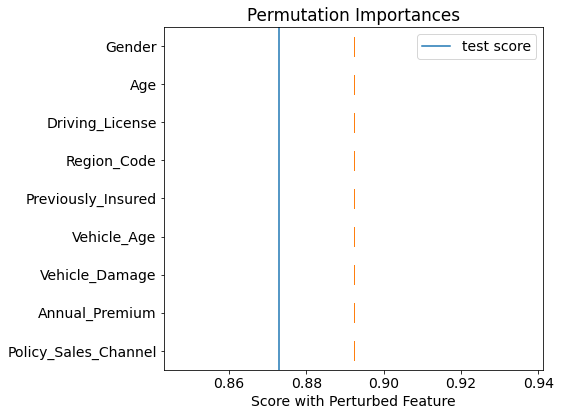

In [15]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[:10][::-1] #order features by how important they are - by how much accuracy score has reduced 
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(mean_test_scores,label='test score') #original test score
plt.title("Permutation Importances")
plt.xlabel("Score with Perturbed Feature")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('Figures/RF_PermutationScores.png', dpi=300, format='png')

### Confusion Matrix

In [22]:
rf_clf = RandomForestClassifier(n_estimators = 100,random_state=42)
rf_clf.fit(X_train_prep,y_train)
y_true = (y_test)
y_pred = rf_clf.predict(X_test_prep)
print(confusion_matrix(y_true,y_pred))

[[62954  3918]
 [ 7376  1974]]


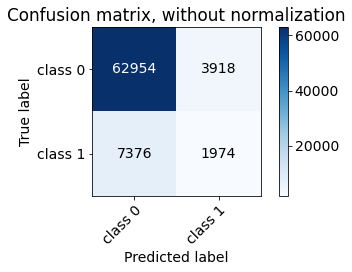

In [24]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(y_true,y_pred,classes=['class 0','class 1'])
plt.show()
plt.savefig('Figures/RF_ConfusionMatrix.png', dpi=300, format='png')